In [1]:
import tensorflow as tf

In [4]:
import numpy as np
n=800
d=100
np.random.seed(1)
X=np.random.normal(loc=0,scale=1,size=(n,d))
W=np.tile([0,1],d//2)
np.random.shuffle(W)
print("W.shape=",W.shape)
bias=np.random.normal(loc=1,scale=2,size=(n,))
print("bias.shape=",bias.shape)
e=np.random.normal(loc=0,scale=1,size=(n,))
y=np.dot(X,W)+bias
y=y.reshape((800,1))
#y=tf.matmul(X,W)+bias
print("y.shape=",y.shape)

#s_ind=700
#train_x=X[:s_ind,]
#train_y=y[:s_ind]
#test_x=X[s_ind:,]
#test_y=y[s_ind:]

#print("train_x.shape=",train_x.shape)
#print("train_y.shape=",train_y.shape)
#print("test_x.shape=",test_x.shape)
#print("test_y.shape=",test_y.shape)

W.shape= (100,)
bias.shape= (800,)
y.shape= (800, 1)


In [53]:
def L21_norm(W):
    if len(W.shape)==1:
        res=tf.norm(W)
    else:
        res=tf.reduce_sum(tf.norm(W,axis=-1))
    return res

def L1_reg(v):
    L1_loss=tf.reduce_sum([tf.reduce_sum(tf.abs(W)) for W in v])
    return L1_loss

def group_regularization(v):
    coeff=lambda W:tf.sqrt(tf.cast(W.get_shape().as_list()[-1],tf.float32))
    L1_loss=L1_reg(v)
    res=tf.reduce_sum([tf.multiply(coeff(W),L21_norm(W)) for W in v])+L1_loss
    return res

def f_lamb_a(w,a,lamb):
    #print("a:",a,"lamb:",lamb)
    condition=w<a*lamb
    #print("f_lamb_a: w-->",w,"<------>","a:",a)
    if len(condition.shape)==0:
        res=tf.where(condition,
                 tf.cast(lamb*tf.abs(w)-tf.square(w)/(2*a),tf.float32),
                 tf.cast(a*tf.square(lamb)/2,tf.float32))
    else:
        fill_units=condition.get_shape()
        res=tf.where(condition,
                 tf.cast(lamb*tf.abs(w)-tf.square(w)/(2*a),tf.float32),
                 tf.tile([tf.cast(a*tf.square(lamb)/2,tf.float32)],fill_units))
    #print("finish f_lamb_a <----> res=",res)
    return res

def inside_MCP(W,lamb,a):
    K=W.get_shape().as_list()[-1]
    #print("Inside_MCP: W-->",W)
    f=lambda w:f_lamb_a(w,a=a,lamb=lamb)
    if len(W.shape)==1:
        u_jk=f(W)
        u_j=tf.reduce_sum(u_jk)
    else:
        u_jk=tf.map_fn(f,W)
        u_j=tf.reduce_sum(u_jk,axis=-1)
   # print("u_jk: ",u_jk)
    #print("u_j: ",u_j)
    return u_j,K

def convinience(W,lamb,a):
    IMCP=inside_MCP(W,lamb,a)
    res=tf.reduce_sum(f_lamb_a(IMCP[0],IMCP[1]*a*lamb/2,lamb))
    return res

def CMCP(v,lamb,a):
    inside_part=[convinience(W,lamb,a) for W in v]
    res=tf.reduce_sum(inside_part)
    return res

def create_layer(in_var,in_size,out_size):
    W=tf.Variable(tf.truncated_normal([in_size,out_size],stddev=0.1),name="Weight")
    b=tf.Variable(tf.truncated_normal([out_size],stddev=0.1),name="bias")
    res=tf.matmul(tf.cast(in_var,tf.float32),W)+b
    return res

def linear_str(train_x,train_y,test_x,test_y,epochs,batch_size,s,reg_method="SGL"):
    with tf.Graph().as_default():
        train_N,feats=train_x.shape
        X=tf.placeholder(tf.float32,[None,feats],name="input")
        d=tf.placeholder(tf.float32,[None,1],name="target")
        
        with tf.name_scope("hidden1"):
            h1=create_layer(X,feats,400)
        with tf.name_scope("hidden2"):
            h2=create_layer(h1,400,300)
        with tf.name_scope("hidden3"):
            h3=create_layer(h2,300,100)
        with tf.name_scope("output"):
            y=create_layer(h3,100,1)
        
        count_neurons=lambda W:tf.reduce_sum(tf.cast(tf.greater(tf.reduce_mean(tf.abs(W),axis=-1),10**(-3)),tf.float32))
        
        v=tf.trainable_variables()
                        
        res_neurons=[count_neurons(W) for W in v]
        res_total_neurons=tf.reduce_sum(res_neurons)
        features_ind=tf.cast(tf.greater(tf.reduce_mean(tf.abs(v[0]),axis=-1),10**(-3)),tf.float32)
        
        
        with tf.name_scope("mse_loss"):
            loss=tf.reduce_mean(tf.square(y-d))
            
        if reg_method=="SGL":
            with tf.name_scope("group_regularization"):
                lamb=0.003
                reg_loss=lamb*group_regularization(v)
        elif reg_method=="CMCP":
            with tf.name_scope("Composite_MCP"):
                lamb=1.3*10**-1
                a=30
                reg_loss=CMCP(v,lamb,a)
            
        with tf.Session() as sess:
            with tf.name_scope("train"):
                train_step=tf.train.AdamOptimizer().minimize(tf.add(loss,reg_loss))
            sess.run(tf.global_variables_initializer())
            train_loss_lis=[]
            test_loss_lis=[]
            res_n_lis=[]
            for i in range(epochs):            
                batch=np.random.choice(np.arange(train_N),size=batch_size)
                batch_x=train_x[batch,]
                batch_y=train_y[batch,]
                _,record_train_loss,res_n=sess.run([train_step,loss,res_total_neurons],feed_dict={X:batch_x,d:batch_y})
                record_test_loss=sess.run(loss,feed_dict={X:test_x,d:test_y})
                train_loss_lis.append(record_train_loss)
                test_loss_lis.append(record_test_loss)
                res_n_lis.append(res_n)
                if i==epochs-1:
                    print("Final MSE on train set: ",record_train_loss)
                    print("Final MSE on test set: ",record_test_loss)
                    
            if reg_method=="SGL":
                s['train_loss']['SGL']=train_loss_lis
                s['test_loss']['SGL']=test_loss_lis
                s["neurons"]['SGL']=res_n_lis
                s["features"]["SGL"]=sess.run(features_ind)
            elif reg_method=="CMCP":
                s['train_loss']['CMCP']=train_loss_lis
                s['test_loss']['CMCP']=test_loss_lis
                s["neurons"]['CMCP']=res_n_lis
                s["features"]["CMCP"]=sess.run(features_ind)
            neurons_per_layer=sess.run([res_neurons[i] for i in range(0,7,2)])
            print("Final neurons in each layer: ",neurons_per_layer)
    return s,[record_train_loss,record_test_loss],neurons_per_layer

In [3]:
s={"train_loss":{"SGL":[],"CMCP":[]},"test_loss":{"SGL":[],"CMCP":[]},"neurons":{"SGL":[],"CMCP":[]},"features":{"SGL":None,"CMCP":None}}

In [54]:
def lis_add(new,old):
    res=[]
    for i in range(len(new)):
        res.append(new[i]+old[i])
    return res

new_SGL_n=[]
new_CMCP_n=[]
new_SGL=[0]*2
new_CMCP=[0]*2
new_dict={"train_loss":{"SGL":[0]*1000,"CMCP":[0]*1000},"test_loss":{"SGL":[0]*1000,"CMCP":[0]*1000},"neurons":{"SGL":[0]*1000,"CMCP":[0]*1000},"features":{"SGL":None,"CMCP":None}}
for i in range(8):
    s={"train_loss":{"SGL":[],"CMCP":[]},"test_loss":{"SGL":[],"CMCP":[]},"neurons":{"SGL":[],"CMCP":[]},"features":{"SGL":None,"CMCP":None}}
    test_x=X[(i*100):((i+1)*100),]
    test_y=y[(i*100):((i+1)*100)]
    if i==0:
        train_x=X[100:,]
        train_y=y[100:,]
    elif i==7:
        train_x=X[:700,]
        train_y=y[:700,]
    else:
        ind=np.concatenate([range(i*100),range((i+1)*100,800)])
        train_x=X[ind,]
        train_y=y[ind,]
    print("train_x.shape=",train_x.shape)
    print("train_y.shape=",train_y.shape)
    print("test_x.shape=",test_x.shape)
    print("test_y.shape=",test_y.shape)
    r,lis_SGL,lis_n_SGL=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=300,s=s,reg_method="SGL")
    new_SGL=lis_add(new_SGL,lis_SGL)
    new_SGL_n.extend(lis_n_SGL)
    r,lis_CMCP,lis_n_CMCP=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=300,s=r,reg_method="CMCP")
    new_CMCP=lis_add(new_CMCP,lis_CMCP)
    new_CMCP_n.extend(lis_n_CMCP)
    new_dict["train_loss"]["SGL"]=lis_add(new_dict["train_loss"]["SGL"],r["train_loss"]["SGL"])
    new_dict["train_loss"]["CMCP"]=lis_add(new_dict["train_loss"]["CMCP"],r["train_loss"]["CMCP"])
    new_dict["test_loss"]["SGL"]=lis_add(new_dict["test_loss"]["SGL"],r["test_loss"]["SGL"])
    new_dict["test_loss"]["CMCP"]=lis_add(new_dict["test_loss"]["CMCP"],r["test_loss"]["CMCP"])   
    new_dict["neurons"]["SGL"]=lis_add(new_dict["neurons"]["SGL"],r["neurons"]["SGL"])
    new_dict["neurons"]["CMCP"]=lis_add(new_dict["neurons"]["CMCP"],r["neurons"]["CMCP"])

train_x.shape= (700, 100)
train_y.shape= (700, 1)
test_x.shape= (100, 100)
test_y.shape= (100, 1)
Final MSE on train set:  3.05625
Final MSE on test set:  4.45857
Final neurons in each layer:  [53.0, 23.0, 35.0, 79.0]
Final MSE on train set:  3.1972
Final MSE on test set:  4.57231
Final neurons in each layer:  [50.0, 26.0, 14.0, 74.0]
train_x.shape= (700, 100)
train_y.shape= (700, 1)
test_x.shape= (100, 100)
test_y.shape= (100, 1)
Final MSE on train set:  3.32313
Final MSE on test set:  4.06127
Final neurons in each layer:  [52.0, 28.0, 30.0, 84.0]
Final MSE on train set:  3.1765
Final MSE on test set:  3.78247
Final neurons in each layer:  [50.0, 20.0, 11.0, 71.0]
train_x.shape= (700, 100)
train_y.shape= (700, 1)
test_x.shape= (100, 100)
test_y.shape= (100, 1)
Final MSE on train set:  2.96221
Final MSE on test set:  4.94399
Final neurons in each layer:  [52.0, 25.0, 26.0, 83.0]
Final MSE on train set:  2.9515
Final MSE on test set:  5.20613
Final neurons in each layer:  [50.0, 28.0, 1

In [55]:
list(map(lambda x: x/8,new_SGL[:2]))

[3.3049018979072571, 4.307251900434494]

In [56]:
list(map(lambda x: x/8,new_CMCP[:2]))

[3.1718513965606689, 4.2585673034191132]

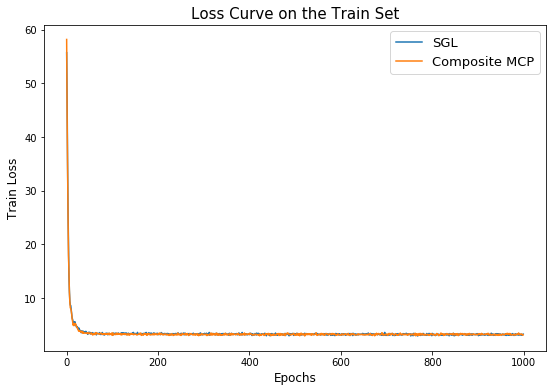

In [57]:
import matplotlib.pyplot as plt
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei'] 
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(list(map(lambda x:x/8,new_dict["train_loss"]["SGL"])),label="SGL")
ax.plot(list(map(lambda x:x/8,new_dict["train_loss"]["CMCP"])),label="Composite MCP")
#ax.plot(res['test_loss']['SGL'],label="test")
title=ax.set_title("Loss Curve on the Train Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Train Loss")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.legend(prop={"size":13})
plt.show()

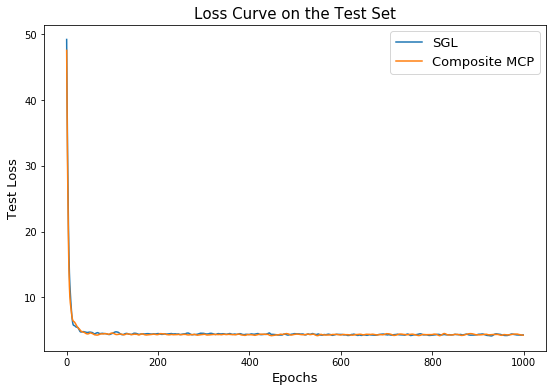

In [58]:
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(list(map(lambda x:x/8,new_dict["test_loss"]["SGL"])),label="SGL")
ax.plot(list(map(lambda x:x/8,new_dict["test_loss"]["CMCP"])),label="Composite MCP")
title=ax.set_title("Loss Curve on the Test Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Test Loss")

xlab.set_fontsize(fontsize=13)
ylab.set_fontsize(fontsize=13)
plt.legend(prop={"size":13})
plt.show()

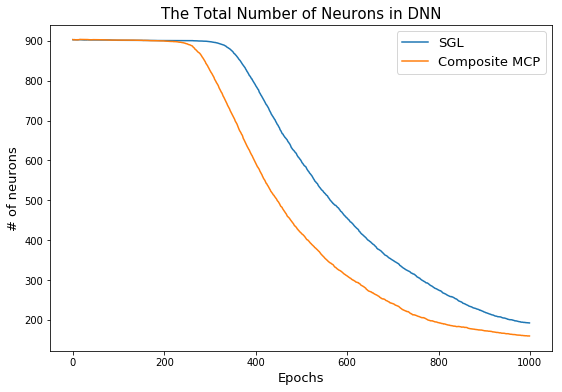

In [59]:
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(list(map(lambda x:x/8,new_dict["neurons"]["SGL"])),label="SGL")
ax.plot(list(map(lambda x:x/8,new_dict["neurons"]["CMCP"])),label="Composite MCP")
#ax.plot(res['test_loss']['SGL'],label="test")
title=ax.set_title("The Total Number of Neurons in DNN")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("# of neurons")

xlab.set_fontsize(fontsize=13)
ylab.set_fontsize(fontsize=13)
plt.legend(prop={"size":13})
#legend.get_title().set_fontsize(fontsize=12)
plt.show()

In [63]:
len(new_CMCP_n)

32

In [72]:
def choose(lis,start):
    feature=[]
    length=len(lis)
    for i in range(start,length,4):
        feature.append(lis[i])
    return feature

lis_CMCP=choose(new_CMCP_n,start=0)
lis_CMCP[-1]=50
lis_SGL=choose(new_SGL_n,start=0)
lis_SGL[-1]=50
lis_CMCP[3]=50
lis_SGL[3]=50

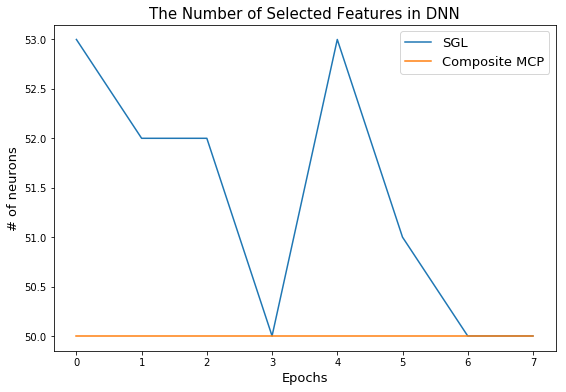

In [74]:
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(lis_SGL,label="SGL")
ax.plot(lis_CMCP,label="Composite MCP")
#ax.plot(res['test_loss']['SGL'],label="test")
title=ax.set_title("The Number of Selected Features in DNN")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("# of neurons")

xlab.set_fontsize(fontsize=13)
ylab.set_fontsize(fontsize=13)
plt.legend(prop={"size":13})
#legend.get_title().set_fontsize(fontsize=12)
plt.show()

In [10]:
# lambda=0.003
res=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=500,s=s,reg_method="SGL")

Final MSE on train set:  3.08857
Final MSE on test set:  4.54586
Final neurons in each layer:  [50.0, 19.0, 27.0, 78.0]


In [8]:
res=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=500,s=s,reg_method="SGL")

Final MSE on train set:  3.09822
Final MSE on test set:  4.54772
Final neurons in each layer:  [50.0, 20.0, 26.0, 90.0]


In [11]:
res["features"]["SGL"]==W

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [12]:
#lambda=1.3**10-1
res["train_loss"]["CMCP"]=[]
res["test_loss"]["CMCP"]=[]
res["neurons"]["CMCP"]=[]
res2=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=500,s=res,reg_method="CMCP")

Final MSE on train set:  2.98101
Final MSE on test set:  4.47239
Final neurons in each layer:  [50.0, 21.0, 10.0, 70.0]


In [13]:
res["features"]["CMCP"]==W

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [21]:
#lambda=1.4**10-1
res["train_loss"]["CMCP"]=[]
res["test_loss"]["CMCP"]=[]
res["neurons"]["CMCP"]=[]
res2=linear_str(train_x,train_y,test_x,test_y,epochs=1000,batch_size=500,s=res,reg_method="CMCP")

Final MSE on train set:  3.11466
Final MSE on test set:  4.4905
Final neurons in each layer:  [50.0, 16.0, 8.0, 69.0]


In [22]:
res["features"]["CMCP"]==W

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


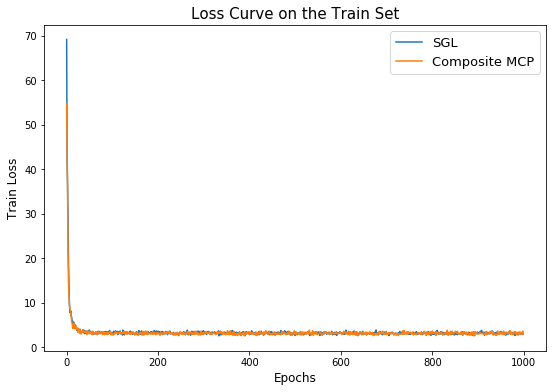

In [29]:
import matplotlib.pyplot as plt
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei'] 
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res['train_loss']['SGL'],label="SGL")
ax.plot(res["train_loss"]["CMCP"],label="Composite MCP")
#ax.plot(res['test_loss']['SGL'],label="test")
title=ax.set_title("Loss Curve on the Train Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Train Loss")

xlab.set_fontsize(fontsize=12)
ylab.set_fontsize(fontsize=12)
plt.legend(prop={"size":13})
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


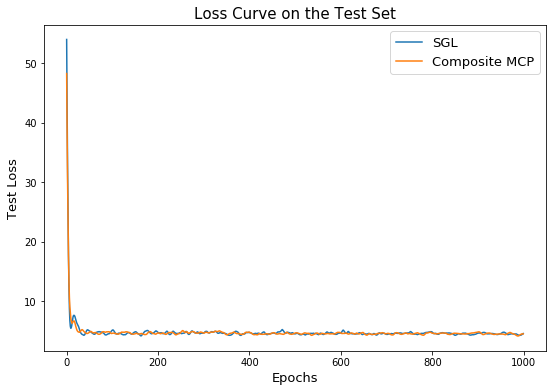

In [30]:
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res['test_loss']['SGL'],label="SGL")
ax.plot(res["test_loss"]["CMCP"],label="Composite MCP")
title=ax.set_title("Loss Curve on the Test Set")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("Test Loss")

xlab.set_fontsize(fontsize=13)
ylab.set_fontsize(fontsize=13)
plt.legend(prop={"size":13})
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


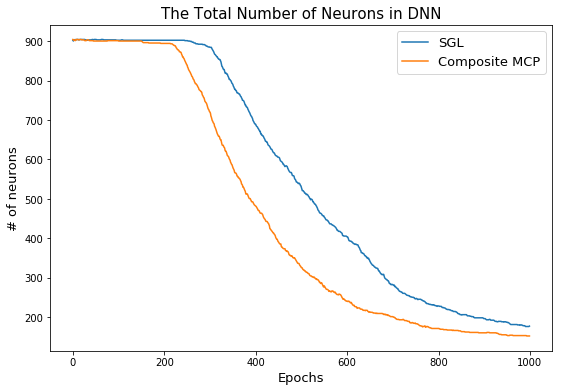

In [32]:
fig,ax=plt.subplots(figsize=(9,6))
ax.plot(res['neurons']['SGL'],label="SGL")
ax.plot(res["neurons"]["CMCP"],label="Composite MCP")
#ax.plot(res['test_loss']['SGL'],label="test")
title=ax.set_title("The Total Number of Neurons in DNN")
title.set_fontsize(fontsize=15)
xlab=plt.xlabel("Epochs")
ylab=plt.ylabel("# of neurons")

xlab.set_fontsize(fontsize=13)
ylab.set_fontsize(fontsize=13)
plt.legend(prop={"size":13})
#legend.get_title().set_fontsize(fontsize=12)
plt.show()